In [13]:
import pandas as pd
# import nbinteract as nbi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import mpld3
from datetime import datetime, timedelta

%matplotlib inline
mpld3.enable_notebook()

In [2]:
sick = pd.read_csv("https://raw.githubusercontent.com/klupp/opendata/master/mk/covid19/datasets/infected_by_municipality.csv")
sick = sick.groupby('date')['count'].sum()

In [3]:
tests = pd.read_csv("https://raw.githubusercontent.com/klupp/opendata/master/mk/covid19/datasets/tests_total.csv")
tests = tests.groupby('date')['count'].sum()

In [4]:
percentage = sick.combine(tests, lambda scount, tcount: scount * 100.0 / tcount)
percentage.fillna(0, inplace=True)

In [34]:
# join the three datasets
res = pd.concat([sick, tests, percentage], axis=1, keys=['Новозаразени', 'Тестирани', 'Процент'])

# add missing dates
yesterday = datetime.today() - timedelta(days=1)
idx = pd.date_range('2020-02-15', datetime.date(yesterday))
res.index = pd.DatetimeIndex(res.index)
res = res.reindex(idx)

res['date'] = res.index # get the index as date column
res.reset_index(drop=True, inplace=True) # drop the index
res.sort_values(by='date', inplace=True) # sort by the date column
res.fillna(0, inplace=True) # fill nans with 0

In [35]:
res_melt = pd.melt(res, id_vars=['date'], value_vars=['Новозаразени', 'Тестирани', 'Процент'])

In [78]:
def draw_line_plot(date_range, line_visibility, data):
    from_day = date_range[0]
    to_day = date_range[1]
    interesting_data = data.loc[(data['date'] >= from_day)
                                & (data['date'] <= to_day)
                                & data['variable'].isin(line_visibility)]

    figure = plt.figure(num='figure', figsize=(15,10))
    ax = plt.axes()
    colors = list(sns.color_palette())
    line_plot = sns.lineplot(x="date", y="value", hue='variable', data=interesting_data, style="variable",
                             markers=True, dashes=False, ax = ax,
                             palette=dict(Новозаразени=colors[0], Тестирани=colors[1], Процент=colors[2]))
    line_plot.set(xlabel='Датум', ylabel='')
    ax.legend(loc='upper left').texts[0].set_text("Легенда:")
    line_plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    line_plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    for line in line_plot.get_lines():
        labels = [x if isinstance(x, int) else round(x, 2) for x in line.get_ydata().tolist()]
        mpld3.plugins.connect(figure, mpld3.plugins.PointLabelTooltip(line, labels=labels))
    
    return line_plot

In [79]:
style = {'description_width': 'initial'}
layout = widgets.Layout(display='flex',
                justify_content='center',
                width='80%')

dates = pd.date_range('2020-02-15', datetime.date(datetime.now()))
options = [(date.strftime(' %d/%m/%Y '), date) for date in dates]
index = (0, len(options) - 1)

date_range_picker = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Период:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    style=style,
    layout=layout
)

line_selector = widgets.SelectMultiple(
    options=['Новозаразени', 'Тестирани', 'Процент'],
    value=['Новозаразени', 'Тестирани', 'Процент'],
    description='Изберете кои линиски дијаграми сакате да бидат покажани:',
    disabled=False,
    style = style,
    layout=layout
)

In [80]:
p = interact(draw_line_plot, date_range=date_range_picker, line_visibility=line_selector, data=fixed(res_melt))

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Период:', index=(0, 85), layo…

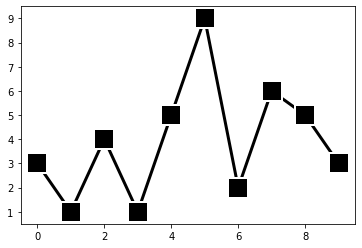

In [19]:


%matplotlib inline
import matplotlib.pyplot as plt, mpld3
mpld3.enable_notebook()



y = [3,1,4,1,5,9,2,6,5,3]
lines = plt.plot(y, 'ks-', mec='w', ms=20, mew=2, lw=3)
plt.axis(xmin=-.5, xmax=9.5, ymin=.5, ymax=9.5)

tooltips = mpld3.plugins.PointLabelTooltip(lines[0], labels=y)
mpld3.plugins.connect(plt.gcf(), tooltips)



In [ ]:
type(plt.gcf())